# **Deep Learning - CSE4006**
# LAB 9

> ## Name: **K CHARVI**
> ## Reg No: 19BCE7002
> ## Date: 08|11|2021
> ## Submitted To: Dr. BKSP Kumarraju Alluri


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# DEEP FAKES

# Q1 : FACE SWAPPING BETWEEN TWO IMAGES

## Importing Packages

In [4]:
import cv2
import numpy as np
import dlib
import time
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from skimage.transform import resize

## Loading data

In [5]:
img = cv2.imread("/content/drive/MyDrive/Deep learning LAB/LAB9/myimg.jpeg")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img2 = cv2.imread("/content/drive/MyDrive/Deep learning LAB/LAB9/got-05.png")
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

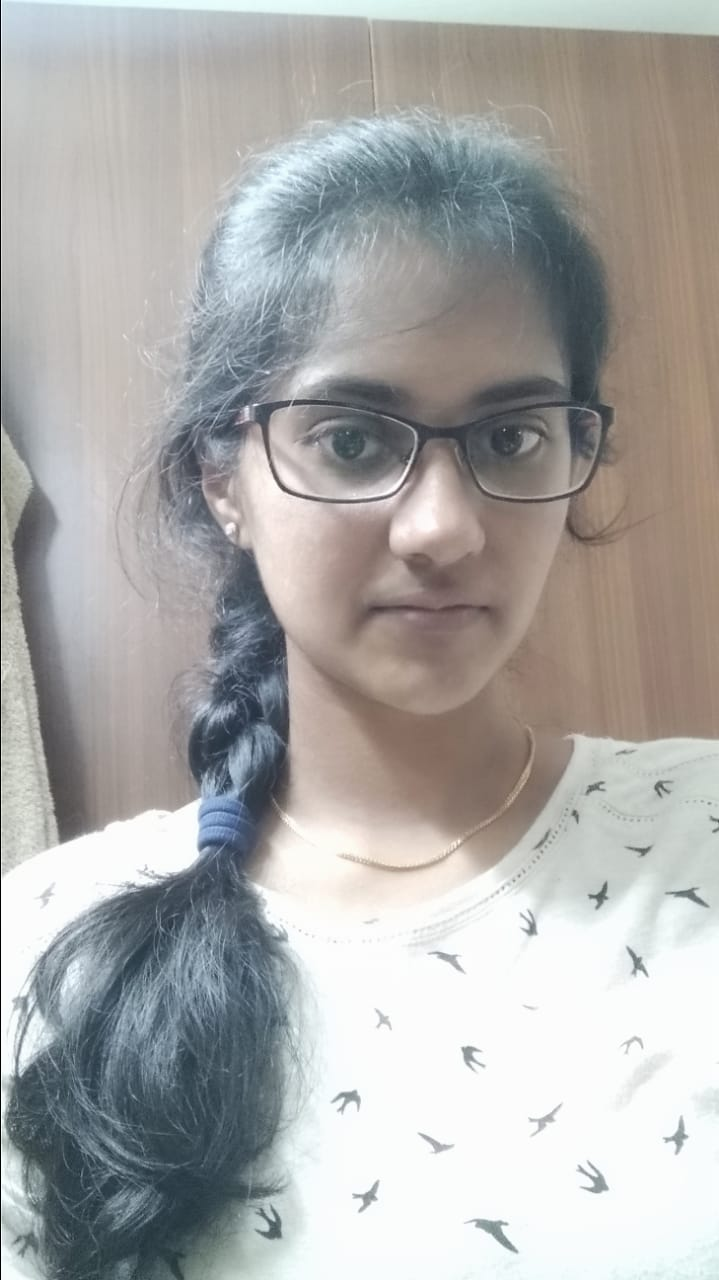

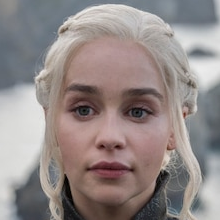

<Figure size 432x288 with 0 Axes>

In [6]:
cv2_imshow(img)

plt.figure()

cv2_imshow(img2)

## Loading dlib library

The `dlib` library is used to detect landmark points 

Facial landmarks(landmark) are used to localize and represent important regions of the face, such as:

· Mouth

· Eyes

· Eyebrows

· Nose

###  dlib.get_frontal_face_detector() → dlib::object_detector<dlib::scan_fhog_pyramid<dlib::pyramid_down<6u>, dlib::default_fhog_feature_extractor> >
### Returns the default face detector

In [7]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/content/drive/MyDrive/Deep learning LAB/LAB9/shape_predictor_68_face_landmarks.dat")
height, width, channels = img2.shape
img2_new_face = np.zeros((height, width, channels), np.uint8)

## Finding Landmark points for face-1 & face-2

In [8]:
def extract_index_nparray(nparray):
    index = None
    for num in nparray[0]:
        index = num
        break
    return index

In [9]:
mask = np.zeros_like(img_gray)

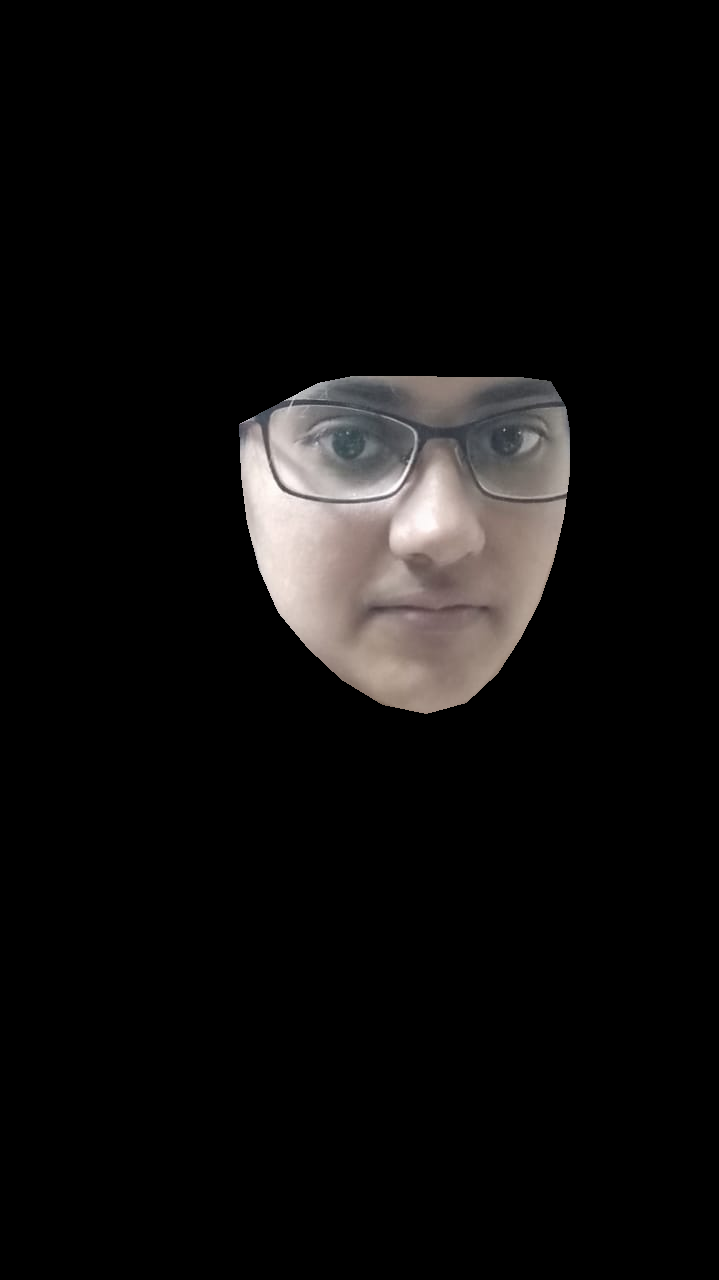

In [10]:
#Face 1
faces = detector(img_gray)
for face in faces:
    landmarks = predictor(img_gray, face)
    landmarks_points = []
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points.append((x, y))



    points = np.array(landmarks_points, np.int32)
    convexhull = cv2.convexHull(points)
    # cv2.polylines(img, [convexhull], True, (255, 0, 0), 3)
    cv2.fillConvexPoly(mask, convexhull, 255)

    face_image_1 = cv2.bitwise_and(img, img, mask=mask)
    cv2_imshow(face_image_1)

    #Delaunay triangulation
    rect = cv2.boundingRect(convexhull)
    subdiv = cv2.Subdiv2D(rect)
    subdiv.insert(landmarks_points)
    triangles = subdiv.getTriangleList()
    triangles = np.array(triangles, dtype=np.int32)

    indexes_triangles = []
    for t in triangles:
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])


        index_pt1 = np.where((points == pt1).all(axis=1))
        index_pt1 = extract_index_nparray(index_pt1)

        index_pt2 = np.where((points == pt2).all(axis=1))
        index_pt2 = extract_index_nparray(index_pt2)

        index_pt3 = np.where((points == pt3).all(axis=1))
        index_pt3 = extract_index_nparray(index_pt3)

        if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
            triangle = [index_pt1, index_pt2, index_pt3]
            indexes_triangles.append(triangle)

In [11]:
#Face 2
faces2 = detector(img2_gray)
for face in faces2:
    landmarks = predictor(img2_gray, face)
    landmarks_points2 = []
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points2.append((x, y))


    points2 = np.array(landmarks_points2, np.int32)
    convexhull2 = cv2.convexHull(points2)

lines_space_mask = np.zeros_like(img_gray)
lines_space_new_face = np.zeros_like(img2_gray)
#Triangulation of both faces
for triangle_index in indexes_triangles:
    # Triangulation of the first face
    tr1_pt1 = landmarks_points[triangle_index[0]]
    tr1_pt2 = landmarks_points[triangle_index[1]]
    tr1_pt3 = landmarks_points[triangle_index[2]]
    triangle1 = np.array([tr1_pt1, tr1_pt2, tr1_pt3], np.int32)


    rect1 = cv2.boundingRect(triangle1)
    (x, y, w, h) = rect1
    cropped_triangle = img[y: y + h, x: x + w]
    cropped_tr1_mask = np.zeros((h, w), np.uint8)


    points = np.array([[tr1_pt1[0] - x, tr1_pt1[1] - y],
                       [tr1_pt2[0] - x, tr1_pt2[1] - y],
                       [tr1_pt3[0] - x, tr1_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr1_mask, points, 255)
    

    # Lines space
    cv2.line(lines_space_mask, tr1_pt1, tr1_pt2, 255)
    cv2.line(lines_space_mask, tr1_pt2, tr1_pt3, 255)
    cv2.line(lines_space_mask, tr1_pt1, tr1_pt3, 255)
    lines_space = cv2.bitwise_and(img, img, mask=lines_space_mask)
    

    # Triangulation of second face
    tr2_pt1 = landmarks_points2[triangle_index[0]]
    tr2_pt2 = landmarks_points2[triangle_index[1]]
    tr2_pt3 = landmarks_points2[triangle_index[2]]
    triangle2 = np.array([tr2_pt1, tr2_pt2, tr2_pt3], np.int32)
    

    rect2 = cv2.boundingRect(triangle2)
    (x, y, w, h) = rect2

    cropped_tr2_mask = np.zeros((h, w), np.uint8)

    points2 = np.array([[tr2_pt1[0] - x, tr2_pt1[1] - y],
                        [tr2_pt2[0] - x, tr2_pt2[1] - y],
                        [tr2_pt3[0] - x, tr2_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr2_mask, points2, 255)

    cv2.line(lines_space_new_face, tr2_pt1, tr2_pt2, 255)
    cv2.line(lines_space_new_face, tr2_pt3, tr2_pt2, 255)
    cv2.line(lines_space_new_face, tr2_pt1, tr2_pt3, 255)
    lines_space2 = cv2.bitwise_and(img2, img2, mask=lines_space_new_face)

    # Warp triangles
    points = np.float32(points)
    points2 = np.float32(points2)
    M = cv2.getAffineTransform(points, points2)
    warped_triangle = cv2.warpAffine(cropped_triangle, M, (w, h))
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=cropped_tr2_mask)
    
    

    # Reconstructing destination face
    img2_new_face_rect_area = img2_new_face[y: y + h, x: x + w]
    img2_new_face_rect_area_gray = cv2.cvtColor(img2_new_face_rect_area, cv2.COLOR_BGR2GRAY)
    _, mask_triangles_designed = cv2.threshold(img2_new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)
    

    img2_new_face_rect_area = cv2.add(img2_new_face_rect_area, warped_triangle)
    img2_new_face[y: y + h, x: x + w] = img2_new_face_rect_area
  



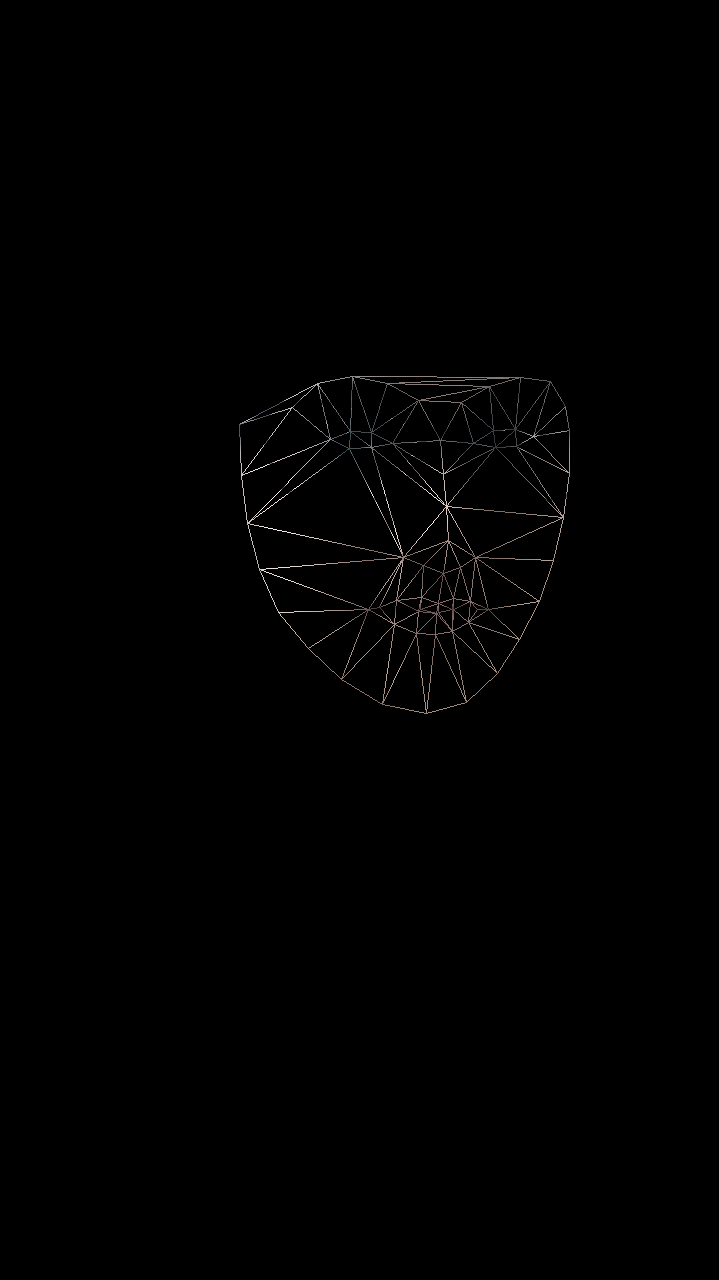

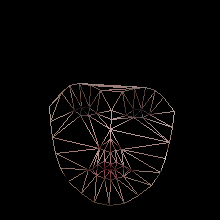

In [12]:
cv2_imshow(lines_space)

cv2_imshow(lines_space2)

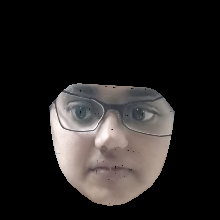

In [13]:
cv2_imshow(img2_new_face)

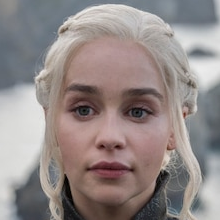

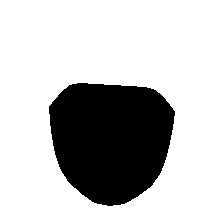

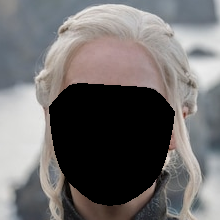

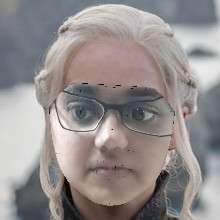

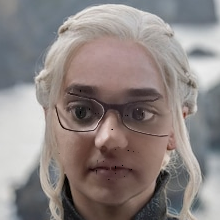

In [14]:
# Face swapped (putting 1st face into 2nd face)
img2_face_mask = np.zeros_like(img2_gray)
img2_head_mask = cv2.fillConvexPoly(img2_face_mask, convexhull2, 255)
img2_face_mask = cv2.bitwise_not(img2_head_mask)


img2_head_noface = cv2.bitwise_and(img2, img2, mask=img2_face_mask)
result = cv2.add(img2_head_noface, img2_new_face)

(x, y, w, h) = cv2.boundingRect(convexhull2)
center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))

seamlessclone = cv2.seamlessClone(result, img2, img2_head_mask, center_face2, cv2.NORMAL_CLONE)
cv2_imshow(img2)
cv2_imshow(img2_face_mask)
cv2_imshow(img2_head_noface)
cv2_imshow(result)
cv2_imshow(seamlessclone)


# Q2 : DeepFake Video


In [15]:
pwd

'/content'

In [16]:
%cd /content/drive/MyDrive/Deep learning LAB/LAB9

/content/drive/MyDrive/Deep learning LAB/LAB9


In [ ]:
mkdir deepfake

mkdir: cannot create directory ‘deepfake’: File exists


In [17]:
cd deepfake/

/content/drive/MyDrive/Deep learning LAB/LAB9/deepfake


In [18]:
pwd

'/content/drive/My Drive/Deep learning LAB/LAB9/deepfake'

## Clone 

In [ ]:
! git clone https://github.com/AliaksandrSiarohin/first-order-model.git

fatal: destination path 'first-order-model' already exists and is not an empty directory.


In [19]:
cd first-order-model

/content/drive/My Drive/Deep learning LAB/LAB9/deepfake/first-order-model


## import packages

In [20]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")

## load data & preprocess

In [21]:
source_image = imageio.imread('/content/drive/MyDrive/Deep learning LAB/LAB9/myimg.jpeg')
driving_video = imageio.mimread('/content/drive/MyDrive/Deep learning LAB/LAB9/08.mp4')



#Resize image and video to 256x256

source_image = resize(source_image, (256, 256))[..., :3]
driving_video = [resize(frame, (256, 256))[..., :3] for frame in driving_video]

def display(source, driving, generated=None):
    fig = plt.figure(figsize=(8 + 4 * (generated is not None), 6))

    ims = []
    for i in range(len(driving)):
        cols = [source]
        cols.append(driving[i])
        if generated is not None:
            cols.append(generated[i])
        im = plt.imshow(np.concatenate(cols, axis=1), animated=True)
        plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    plt.close()
    return ani
    

HTML(display(source_image, driving_video).to_html5_video())

## Create model & load checkpoints

In [22]:
from demo import load_checkpoints
generator, kp_detector = load_checkpoints(config_path='/content/drive/MyDrive/Deep learning LAB/LAB9/deepfake/first-order-model/config/vox-256.yaml', 
                            checkpoint_path='/content/drive/MyDrive/Deep learning LAB/LAB9/vox-cpk.pth.tar')

## perform image animation

In [23]:
from demo import make_animation
from skimage import img_as_ubyte

predictions = make_animation(source_image, driving_video, generator, kp_detector, relative=True)

#save resulting video
imageio.mimsave('../generated.mp4', [img_as_ubyte(frame) for frame in predictions])
#video can be downloaded from /content folder

HTML(display(source_image, driving_video, predictions).to_html5_video())

100%|██████████| 150/150 [00:28<00:00,  5.29it/s]
